Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or tim|elise|david|qi, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [6]:
NAMES = "Melika Ayoughi, Mahsa Mojtahedi"

---

In [7]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Temporal Difference (TD) learning (8 points)
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

disadvantage: you need to wait for the whole episode to finish
advantage: more efficient u don't need to calculate all the possiblities?


------------------- answer

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [18]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

In [19]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    """
    def policy_fn(observation):
        return int(np.random.rand() * nA) if np.random.rand() < epsilon else np.argmax(Q[observation])
    return policy_fn

In [38]:
# env?
# print(env.P[37])
import matplotlib as mpl
mpl.rcParams.update({"figure.figsize": (15, 10)})

100%|██████████| 1000/1000 [00:00<00:00, 1790.82it/s]


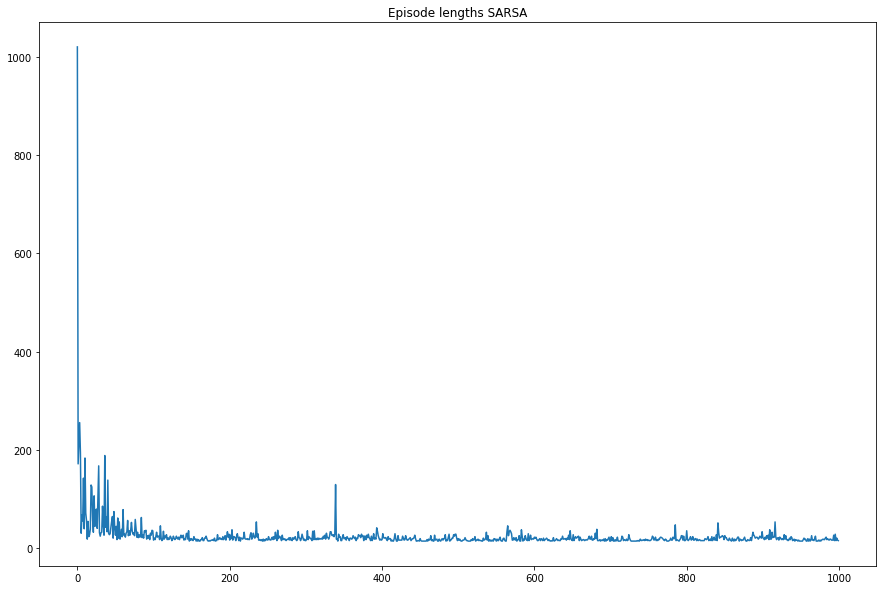

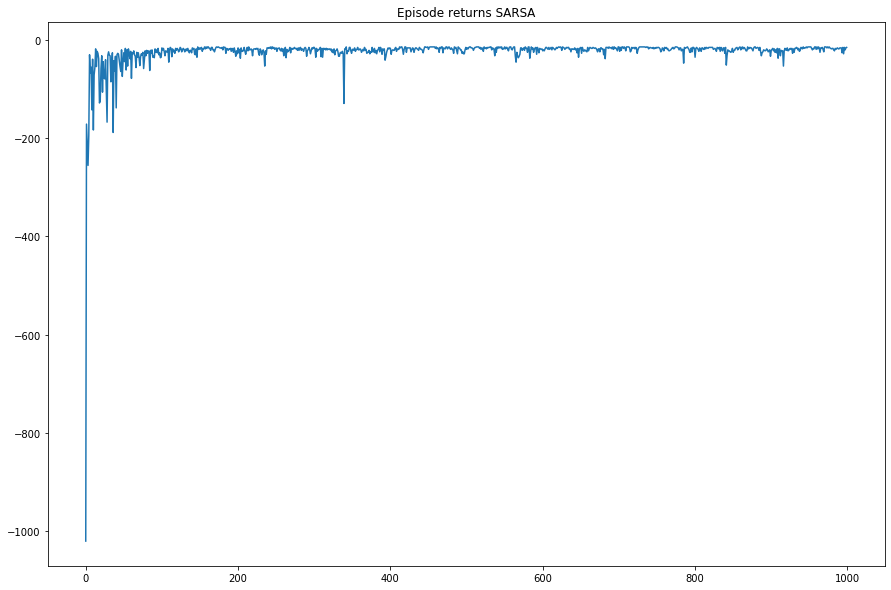

In [39]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        # randomly initialize the first state ?????
#         s = random.choice(list(env.P.keys()))
        s = env.reset()
        a = policy(s)
        stop = False
        rewards = []
        # while we have not reached the goal state
        while stop != True:
            s_next, R, stop, _ = env.step(a)
#             P = env.P[s][a][0]  # take action
#             s_next = P[1]  # observe s'
#             R = P[2]       # observe reward
#             stop = P[3]    # check stop condition (if the next state will be goal)
            a_next = policy(s_next)  # choose next action from policy
            Q[s][a] = Q[s][a] + alpha * (R + discount_factor * Q[s_next][a_next] - Q[s][a])
            s = s_next
            a = a_next
#             P = env.P[s][a][0]
            i += 1  # episode length
            rewards.append(R)
        # calculating the episode return
        discount_powers = np.array(range(i-1,-1,-1))
        discounts = np.array([pow(discount_factor, n) for n in discount_powers])
        episode_return = np.dot(rewards, discounts)
        stats.append((i, episode_return))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(episode_returns_sarsa)
plt.title('Episode returns SARSA')
plt.show()

We learn the optimal (non-exploring) policy while using another policy to do exploration, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

100%|██████████| 1000/1000 [00:00<00:00, 1696.28it/s]


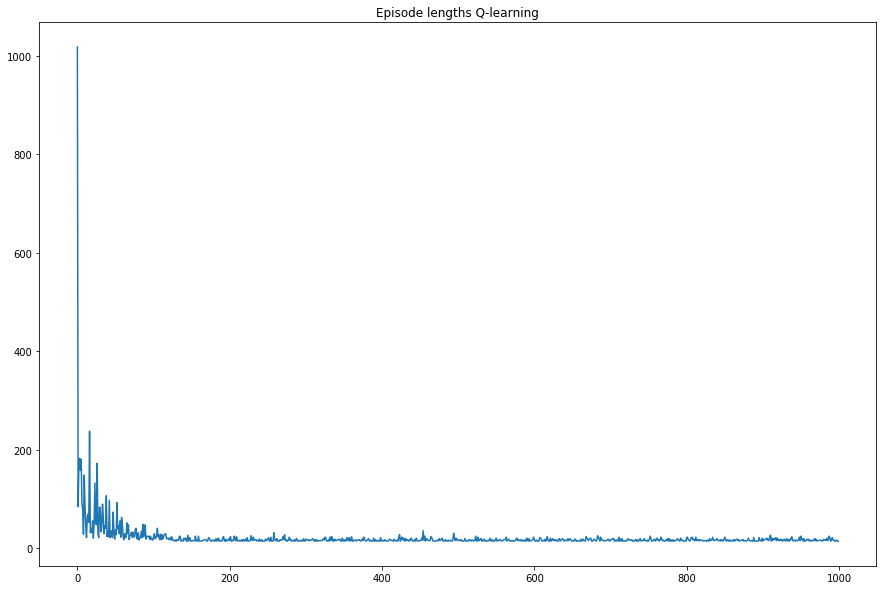

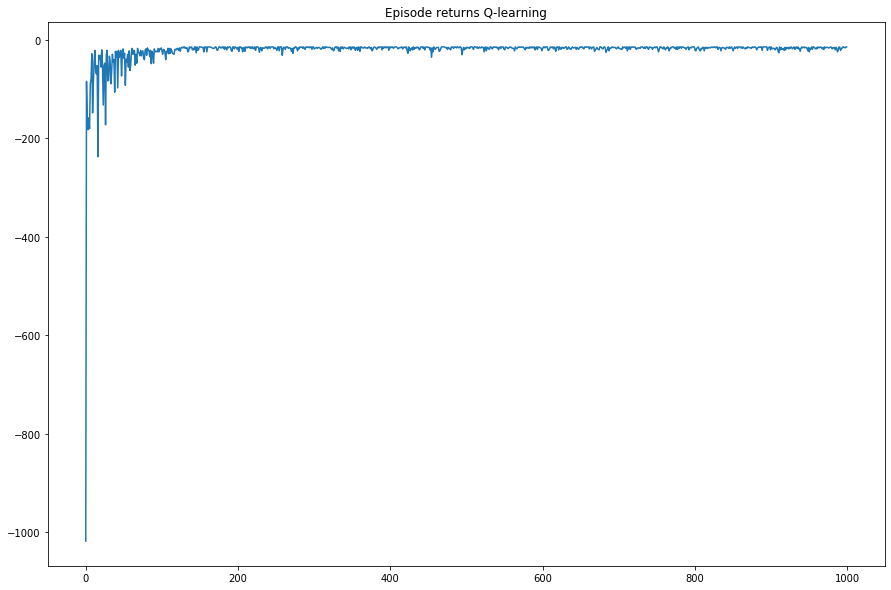

In [40]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
#     print(max(Q[9]))
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        s = env.reset()
        # while we have not reached the goal state
        stop = False
        rewards = []
        while stop != True:
            a = policy(s)  # choose a from s using policy
            s_next, R, stop, _ = env.step(a)
            a_next = policy(s_next)  # choose next action from policy
            Q[s][a] = Q[s][a] + alpha * (R + discount_factor * max(Q[s_next]) - Q[s][a])
            s = s_next
            a = a_next
            i += 1  # episode length
            rewards.append(R)
        # calculating the episode return
        discount_powers = np.array(range(i-1,-1,-1))
        discounts = np.array([pow(discount_factor, n) for n in discount_powers])
        episode_return = np.dot(rewards, discounts)
        stats.append((i, episode_return))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead).

In [24]:
plt.plot(episode_returns_sarsa, episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

NotImplementedError: 

Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

YOUR ANSWER HERE

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

YOUR ANSWER HERE

Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

---
## 2. Deep Q-Network (DQN) (10 points)

In [41]:
import gym
env = gym.envs.make("CartPole-v0")

/Users/melikaayoughi/Desktop/myfavouriteenv/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [42]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [45]:
import time
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.5)
env.close()  # Close the environment or you will have a lot of render screens soon

Remember from the previous lab, that in order to optimize a policy we need to estimate the Q-values (e.g. estimate the *action* values). In the CartPole problem, our state is current position of the cart, the current velocity of the cart, the current (angular) position of the pole and the (angular) speed of the pole. As these are continuous variables, we have an infinite number of states (ignoring the fact that a digital computer can only represent finitely many states in finite memory).

Can you think of a way in which we can still use a tabular approach? Why would this work and can you think of an example problem where this would not work?

YOUR ANSWER HERE

### 2.1 Implement Q-Network

We will not use the tabular approach but approximate the Q-value function by a general approximator function. We will skip the linear case and directly use a two layer Neural Network. We use [PyTorch](https://pytorch.org/) to implement the network, as this will allow us to train it easily later. We can implement a model using `torch.nn.Sequential`, but with PyTorch it is actually very easy to implement the model (e.g. the forward pass) from scratch. Now implement the `QNetwork.forward` function that uses one hidden layer with ReLU activation (no output activation).

In [46]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)
    
    def forward(self, x):
        output_l1 = self.l1(x)
        output_relu = F.relu(output_l1)
        output_l2 = self.l2(output_relu)
        return output_l2

In [47]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = QNetwork(num_hidden)

torch.manual_seed(1234)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(model(x).numpy(), test_model(x).numpy())

### 2.2 Experience Replay

What could be a problem with doing gradient updates on a sequence of state, action pairs $((s_t, a_t), (s_{t+1}, a_{t+1}) ...)$ observed while interacting with the environment? How will using *experience replay* help to overcome this (potential problem)?

YOUR ANSWER HERE

Now implement the `push` function that adds a transition to the replay buffer, and the sample function that returns a batch of samples. It should keep at most the maximum number of transitions. Also implement the `sample` function that samples a (random!) batch of data, for use during training (hint: you can use the function `random.sample`).

In [48]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory) == self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            print('push function has some error, exceeding the memory size.')

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [49]:
capacity = 10
memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))


[(array([ 0.04326486, -0.01471765,  0.02273744, -0.0220162 ]), 1, 1.0, array([ 0.0429705 ,  0.18007097,  0.02229712, -0.30743937]), False)]


### 2.3 $\epsilon$psilon greedy policy

In order to learn a good policy, we need to explore quite a bit initially. As we start to learn a good policy, we want to decrease the exploration. As the amount of exploration using an $\epsilon$-greedy policy is controlled by $\epsilon$, we can define an 'exploration scheme' by writing $\epsilon$ as a function of time. There are many possible schemes, but we will use a simple one: we will start with only exploring (so taking random actions) at iteration 0, and then in 1000 iterations linearly anneal $\epsilon$ such that after 1000 iterations we take random (exploration) actions with 5\% probability (forever, as you never know if the environment will change).

In [16]:
def get_epsilon(it):
    epsilon_start = 1
    epsilon_end = 0.05
    if it <= 1000:
        epsilon = ((epsilon_end - epsilon_start)/(1000-0)) * it + epsilon_start
    else:
        epsilon = epsilon_end
    return epsilon

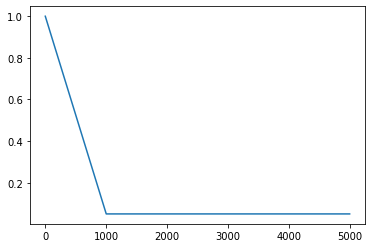

In [17]:
# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])


Now write a function that takes a state and uses the Q-network to select an ($\epsilon$-greedy) action. It should return a random action with probability epsilon (which we will pass later). Note, you do not need to backpropagate through the model computations, so use `with torch.no_grad():` (see above for example). Unlike numpy, PyTorch has no argmax function, but Google is your friend... Note that to convert a PyTorch tensor with only 1 element (0 dimensional) to a simple python scalar (int or float), you can use the '.item()' function.

In [18]:
print(env.action_space.sample())

1


In [19]:
def select_action(model, state, epsilon):
    with torch.no_grad():
        random_switch = random.uniform(0, 1)
        if random_switch <= epsilon:
            return env.action_space.sample()
        else:
            # to avoid error
            x_torch = torch.from_numpy(state).double()
            model = model.double()
            # picking max Q
            value, indice = model(x_torch).max(0)
            return indice.item()

In [20]:
s = env.reset()
a = select_action(model, s, 0.05)
assert not torch.is_tensor(a)
print (a)


1


### 2.4 Training function

Now we will implement the function 'train' that samples a batch from the memory and performs a gradient step using some convenient PyTorch functionality. However, you still need to compute the Q-values for the (state, action) pairs in the experience, as well as their target (e.g. the value they should move towards). What is the target for a Q-learning update? What should be the target if `next_state` is terminal (e.g. `done`)?

For computing the Q-values for the actions, note that the model returns all action values where you are only interested in a single action value. Because of the batch dimension, you can't use simple indexing, but you may want to have a look at [torch.gather](https://pytorch.org/docs/stable/torch.html?highlight=gather#torch.gather) or use [advanced indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) (numpy tutorial but works mostly the same in PyTorch). Note, you should NOT modify the function train. You can view the size of a tensor `x` with `x.size()` (similar to `x.shape` in numpy).

-------------should we answer to their questions here

In [21]:
def compute_q_val(model, state, action):
    # to avoid getting errors
    model = model.double()
    state = state.double()
    action = action[:, None]
    
    q = model(state)
    return torch.gather(q, 1, action).squeeze()
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # to avoid getting errors
    next_state = next_state.double()
    model = model.double()
    done = done.double()
    reward = reward.double()
    
    value, indice = torch.max(model(next_state), dim = 1)
    Q_max = value[0]
    return reward + (1-done) * discount_factor * Q_max

def train(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [22]:
# #--------------!!!!!!!!!!!!!!!!!!!!!!!!!!! this is for testing our functions. delete before handing in.

# # We need a larger memory, fill with dummy data
# memory = ReplayMemory(10 * batch_size)

# # Sample a transition
# s = env.reset()
# a = env.action_space.sample()
# s_next, r, done, _ = env.step(a)
# transition = (s, a, r, s_next, done)
# for i in range(batch_size):
#     memory.push(transition)
    
# transitions = memory.sample(batch_size)
# state, action, reward, next_state, done = zip(*transitions)
# # convert to PyTorch and define types
# state = torch.tensor(state, dtype=torch.float)
# action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
# next_state = torch.tensor(next_state, dtype=torch.float)
# reward = torch.tensor(reward, dtype=torch.float)
# done = torch.tensor(done, dtype=torch.uint8)  # Boolean


# # compute the q value
# q_val = compute_q_val(model, state, action)

# target = compute_target(model, reward, next_state, done, discount_factor)
# print(q_val.size())

In [23]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(model.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)
for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(model, memory, optimizer, batch_size, discount_factor)

print (loss)


0.5871627925449824


### 2.5 Put it all together

Now that you have implemented the training step, you should be able to put everything together. Implement the function `run_episodes` that runs a number of episodes of DQN training. It should return the durations (e.g. number of steps) of each episode. Note: we pass the train function as an argument such that we can swap it for a different training step later.

In [24]:
def run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        # run the episode
        state = env.reset()
        duration = 0
        done = False
        while done == False:
            epsilon = get_epsilon(global_steps)
            action = select_action(model, state, epsilon)
            s_next, r, done, _ = env.step(action)
            transition = (state, action, r, s_next, done)
            memory.push(transition)
            state = s_next
            duration += 1
            global_steps += 1
        # call train
        loss = train(model, memory, optimizer, batch_size, discount_factor)
        episode_durations.append(duration)
    return episode_durations

In [25]:
# Let's run it!
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducability
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)

episode_durations = run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

Text(0.5, 1.0, 'Episode durations per episode')

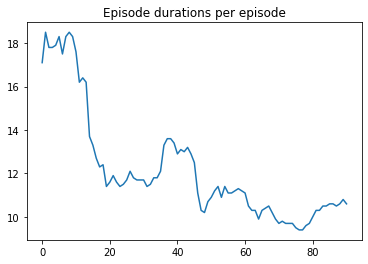

In [26]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')


---

## 3. Policy Gradient (8 points)

So we have spent a lot of time working on *value based* methods. We will now switch to *policy based* methods, i.e. learn a policy directly rather than learn a value function from which the policy follows. Mention two advantages of using a policy based method.

YOUR ANSWER HERE

### 3.1 Policy Network

In order to do so, we will implement a Policy network. Although in general this does not have to be the case, we will use an architecture very similar to the Q-network (two layers with ReLU activation for the hidden layer). Since we have discrete actions, our model will output one value per action, where each value represents the (normalized!) log-probability of selecting that action. *Use the (log-)softmax activation function.*

In [37]:
class PolicyNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        output_l1 = self.l1(x)
        output_relu = F.relu(output_l1)
        output_l2 = self.l2(output_relu)
        output_softmax = F.log_softmax(output_l2)
        return output_softmax

In [38]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = PolicyNetwork(num_hidden)

x = torch.rand(10, 4)

log_p = model(x)

# Does the outcome make sense?
print(log_p.exp())


C:\Users\mahsa\Miniconda3\envs\rl2019\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


tensor([[0.4578, 0.5422],
        [0.4657, 0.5343],
        [0.4563, 0.5437],
        [0.4634, 0.5366],
        [0.4564, 0.5436],
        [0.4725, 0.5275],
        [0.4769, 0.5231],
        [0.4834, 0.5166],
        [0.4797, 0.5203],
        [0.4618, 0.5382]], grad_fn=<ExpBackward>)


### 3.2 Monte Carlo REINFORCE

Now we will implement the *Monte Carlo* policy gradient algorithm. Remember from lab 1 that this means that we will estimate returns for states by sample episodes. Compared to DQN, this means that we do *not* perform an update step at every environment step, but only at the end of each episode. This means that we should generate an episode of data, compute the REINFORCE loss (which requires computing the returns) and then perform a gradient step.

To help you, we already implemented a few functions that you can (but do not have to) use.

* You can use `torch.multinomial` to sample from a categorical distribution.
* The REINFORCE loss is defined as $- \sum_t \log \pi_\theta(a_t|s_t) G_t$, which means that you should compute the (discounted) return $G_t$ for all $t$. Make sure that you do this in **linear time**, otherwise your algorithm will be very slow! Note the - (minus) since you want to maximize return while you want to minimize the loss.
* Importantly, you should **normalize the returns** (not the rewards!, e.g. subtract mean and divide by standard deviation within the episode) before computing the loss, or your estimator will have very high variance.

In [74]:
def select_action(model, state):
    # Samples an action according to the probability distribution induced by the model
    # Also returns the log_probability
    x_torch = torch.from_numpy(state).double()
    model = model.double()
    
    log_p = model(x_torch)
    action = torch.multinomial(torch.exp(log_p), 1).item()
    return action, log_p[action]

def run_episode(env, model):
    # YOUR CODE HERE
    episode = []
    state = env.reset()
    done = False
    while done == False:
        action, log_p_action = select_action(model, state)
        s_next, r, done, _ = env.step(action)
        state = s_next
        # making the episode
        episode.append([log_p_action, r])
    return episode

def compute_reinforce_loss(episode, discount_factor):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    rewards = [lis[1] for lis in episode] 
    log_ps = [lis[0] for lis in episode] 
    # discounting the rewards
    discount_powers = np.array(range(len(rewards)-1,-1,-1))
    discounts = np.array([pow(discount_factor, n) for n in discount_powers])
    discounted_rewards = discounts * rewards
    # calculating the G
    G = np.cumsum(discounted_rewards, axis = 0)
    # normalizing
    G = G - G.mean()
    G = G / G.std()
    # calculating loss
    loss = (-(log_ps * G).sum())
    return loss

def run_episodes_policy_gradient(model, env, num_episodes, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    for i in range(num_episodes):
        # run episode
        episode = run_episode(env, model)
        loss = compute_reinforce_loss(episode, discount_factor)
        # training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print("{2} Episode {0} finished after {1} steps"
                  .format(i, len(episode), '\033[92m' if len(episode) >= 195 else '\033[99m'))
        episode_durations.append(len(episode))
        
    return episode_durations

C:\Users\mahsa\Miniconda3\envs\rl2019\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


 Episode 0 finished after 19 steps
 Episode 10 finished after 18 steps
 Episode 20 finished after 24 steps
 Episode 30 finished after 11 steps
 Episode 40 finished after 10 steps
 Episode 50 finished after 14 steps
 Episode 60 finished after 10 steps
 Episode 70 finished after 16 steps
 Episode 80 finished after 10 steps
 Episode 90 finished after 10 steps
 Episode 100 finished after 9 steps
 Episode 110 finished after 9 steps
 Episode 120 finished after 10 steps
 Episode 130 finished after 9 steps
 Episode 140 finished after 10 steps
 Episode 150 finished after 10 steps
 Episode 160 finished after 9 steps
 Episode 170 finished after 10 steps
 Episode 180 finished after 10 steps
 Episode 190 finished after 10 steps


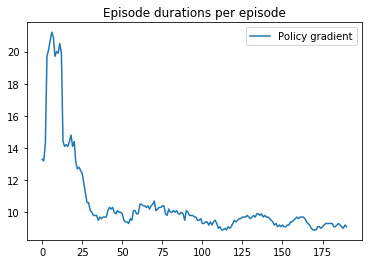

In [75]:
# Feel free to play around with the parameters!
num_episodes = 200
discount_factor = 0.99
learn_rate = 0.01
seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = PolicyNetwork(num_hidden)

episode_durations_policy_gradient = run_episodes_policy_gradient(
    model, env, num_episodes, discount_factor, learn_rate)

plt.plot(smooth(episode_durations_policy_gradient, 10))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])

## 4. Deep Reinforcement Learning (5 bonus points)
Note that so far we used the state variables as input. However, the true power of Deep Learning is that we can directly learn from raw inputs, e.g. we can learn to balance the cart pole *by just looking at the screen*. This probably means that you need a deep(er) (convolutional) network, as well as tweaking some parameters, running for more iterations (perhaps on GPU) and do other tricks to stabilize learning. Can you get this to work? This will earn you bonus points!

Hints:
* You may want to use [Google Colab](https://colab.research.google.com/) such that you can benefit from GPU acceleration.
* Even if you don't use Colab, save the weights of your final model and load it in the code here (see example below). Hand in the model file with the .ipynb in a .zip. We likely won't be able to run your training code during grading!
* Preprocessing is already done for you, and the observation is the difference between two consequtive frames such that the model can 'see' (angular) speed from a single image. Now do you see why we (sometimes) use the word observation (and not state)?

In [ ]:
import torchvision.transforms as T
from PIL import Image


resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

class CartPoleRawEnv(gym.Env):
    
    def __init__(self, *args, **kwargs):
        self._env = gym.make('CartPole-v0', *args, **kwargs)  #.unwrapped
        self.action_space = self._env.action_space
        screen_height, screen_width = 40, 80  # TODO
        self.observation_space = gym.spaces.Box(
            low=0, high=255, 
            shape=(screen_height, screen_width, 3), dtype=np.uint8)
    
    def seed(self, seed=None):
        return self._env.seed(seed)
    
    def reset(self):
        s = self._env.reset()
        self.prev_screen = self.screen = self.get_screen()
        return self._get_observation()
    
    def step(self, action):
        s, r, done, info = self._env.step(action)
        self.prev_screen = self.screen
        self.screen = self.get_screen()
        return self._get_observation(), r, done, info
    
    def _get_observation(self):
        return self.screen - self.prev_screen
    
    def _get_cart_location(self, screen_width):
        _env = self._env.unwrapped
        world_width = _env.x_threshold * 2
        scale = screen_width / world_width
        return int(_env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

    def get_screen(self):
        screen = self._env.unwrapped.render(mode='rgb_array').transpose(
            (2, 0, 1))  # transpose into torch order (CHW)
        # Strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, screen_height * 4 // 10:screen_height * 8 // 10]
        view_width = screen_height * 8 // 10
        cart_location = self._get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescare, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        #return screen.unsqueeze(0).to(device)
        return resize(screen).unsqueeze(0)
    
    def close(self):
        return self._env.close()

raw_env = CartPoleRawEnv()
s = raw_env.reset()

# 
s, r, done, _ = raw_env.step(env.action_space.sample())

raw_env.reset()
plt.figure()
plt.imshow(raw_env.get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

# Observations are (-1, 1) while we need to plot (0, 1) so show (rgb + 1) / 2
plt.figure()
plt.imshow((s.cpu().squeeze(0).permute(1, 2, 0).numpy() + 1) / 2,
           interpolation='none')
plt.title('Example observation')
plt.show()
raw_env.close()

In [ ]:
# Maybe you should make it a bit deeper?
class DeepPolicy(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(40 * 80 * 3, 2)

    def forward(self, x):
        # Flatten
        return F.log_softmax(self.l1(x.view(x.size(0), -1)), -1)
    
policy = DeepPolicy()
filename = 'weights.pt'

if os.path.isfile(filename):
    print(f"Loading weights from {filename}")
    weights = torch.load(filename, map_location='cpu')
    
    policy.load_state_dict(weights['policy'])
    
else:
    # Train
    
    ### TODO some training here, maybe? Or run this on a different machine?
    torch.manual_seed(42)
    
    print(f"Saving weights to {filename}")
    torch.save({
        # You can add more here if you need, e.g. critic
        'policy': policy.state_dict()  # Always save weights rather than objects
    },
    filename)
    
def bonus_get_action(x):
    return policy(x).exp().multinomial(1)[:, 0]

In [ ]:
seed = 42
episode_durations = []
for i in range(20):  # Not too many since it may take forever to render
    test_env = CartPoleRawEnv()
    test_env.seed(seed + i)
    state = test_env.reset()
    done = False
    steps = 0
    while not done:
        steps += 1
        with torch.no_grad():
            action = bonus_get_action(state).item()
        state, reward, done, _ = test_env.step(action)
    episode_durations.append(steps)
    test_env.close()
    
plt.plot(episode_durations)
plt.title('Episode durations')
plt.show()
